In [3]:
import sys
sys.path.append("../")

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from torch.nn.utils.rnn import pack_padded_sequence
import torchvision as tv
import torch.utils.data as td
from torch.nn import functional as F
from torch import nn
import torch

import models.nntools_modified as nt
import models.framework as fw
import utils.config as cfg
from utils.datareader_toy import toyScenesdata

from utils.visualization import *

from PIL import Image
import imageio

In [7]:
net = fw.MultiAgentNetwork(cfg.FCN_OUT, cfg.NUM_INTENTS, cfg.SCENE_OUT,
                                cfg.INTENT_IN, cfg.INTENT_OUT, cfg.SCORE_IN)
net = net.to(device)

dataset = toyScenesdata(set_name="test", traj_time=cfg.PAST_TRAJECTORY_TIME)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

test_set = toyScenesdata(set_name="test")
output_dir = "data/res_gpu_original_downsample_epoch_150_pt_5s/"

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)



Read in 1000 
700
200
100
Read in 1000 
700
200
100


In [11]:
def load_state_dict(checkpoint):
    """Loads the experiment from the input checkpoint."""
    net.load_state_dict(checkpoint['Net'])
    optimizer.load_state_dict(checkpoint['Optimizer'])
    history = checkpoint['History']

    # The following loops are used to fix a bug that was
    # discussed here: https://github.com/pytorch/pytorch/issues/2830
    # (it is supposed to be fixed in recent PyTorch version)
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(net.device)

def load():
    """Loads the experiment from the last checkpoint saved on disk."""
    checkpoint = torch.load(checkpoint_path,
                            map_location=net.device)
    load_state_dict(checkpoint)
#     del checkpoint

In [12]:
test_loader = td.DataLoader(test_set, batch_size=cfg.BATCH_SIZE, shuffle=cfg.SHUFFLE, drop_last=cfg.DROP_LAST, pin_memory=True)

# Initialize history
history = []

# Define checkpoint paths
# if output_dir is None:
#     output_dir = 'experiment_{}'.format(time.time())
# os.makedirs(output_dir, exist_ok=True)
checkpoint_path = os.path.join(output_dir, "checkpoint.pth.tar")
config_path = os.path.join(output_dir, "config.txt")

# Transfer all local arguments/variables into attributes
# locs = {k: v for k, v in locals().items() if k is not 'self'}
# self.__dict__.update(locs)

# Load checkpoint and check compatibility
if os.path.isfile(config_path):
    with open(config_path, 'r') as f:
        if f.read()[:-1] != repr(self):
            raise ValueError(
                "Cannot create this experiment: "
                "I found a checkpoint conflicting with the current setting.")
    load()

In [13]:
net.eval()

MultiAgentNetwork(
  (cross_entropy): CrossEntropyLoss()
  (scene): ResnetSceneContext(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): Batch

(480, 640, 4)
Displaying input to the network


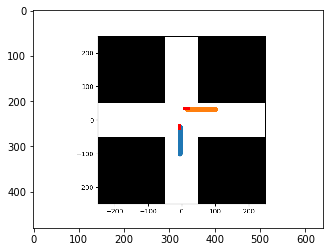

Displaying Groundtruth complete trajectory
Displaying Predicted complete trajectory
Collision occurred for new intents


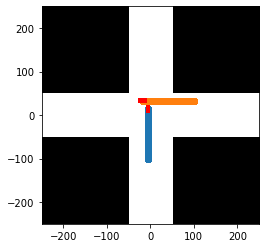

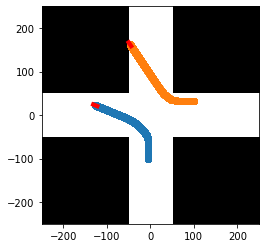

In [11]:
# TODO - replace these with the inputs used for the network
# ls - the entire groundtruth trajectory of the agent
# vs - the entire groundtruth velocities of the agent

# ls, vs -> required for plotting the actual trajectories
# vs additionally required for the initial velocity value
# s_points -> refers to the actual data that is used in init.npy file.
# these are the starting conditions set initially for the image
s_points = np.load("../data/toydataset/2/2716/init.npy", allow_pickle=True)
vs = np.load("../data/toydataset/2/2716/vs.npy")
ls = np.load("../data/toydataset/2/2716/ls.npy")
im = imageio.imread("../data/toydataset/2/2716/scene.png")
print(im.shape)

print("Displaying input to the network")
fig = plt.figure()
plt.imshow(im)
# plt.savefig("test_input.png")
plt.show()

# TODO - compute the new intents from the network
new_intents = np.array([2, 3])
f, f_new, c = visualize(new_intents, s_points, ls, vs)
# f.savefig("test_old.png")
# f_new.savefig("test_new.png")
print("Displaying Groundtruth complete trajectory")
f.show()
print("Displaying Predicted complete trajectory")
f_new.show()
if c:
    print("Collision occurred for new intents")
else:
    print("Successful new trajectory was generated")